In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json, os, sys
import pickle
pd.set_option("display.max_columns", None)

if os.path.join("..", "src") not in sys.path:
    sys.path.append(os.path.join("..", "src"))
from gtfs_cleaning import load_gtfs_data_from_zip

In [3]:
config_path = Path("../config.json")

# Load the JSON file and resolve paths dynamically based on the location of config.json
with config_path.open() as file:
    config = json.load(file)
config["data_GTFS_folder"] = str((config_path.parent / config["data_GTFS_folder"]).resolve())
config["data_GIS_folder"] = str((config_path.parent / config["data_GIS_folder"]).resolve())
config["outputs_folder"] = str((config_path.parent / config["outputs_folder"]).resolve())

In [4]:
# If you want to load all the data, make gtfs_to_load = None.
gtfs_to_load = ['stops', 'stop_times', 'trips', 'routes',
                'fare_attributes', 'fare_rules', 'shapes'] 

gtfs_zip_path = os.path.join(config['data_GTFS_folder'], 'gtfs.zip')

gtfs_data = load_gtfs_data_from_zip(gtfs_zip_path, gtfs_to_load)

# Promote each loaded DataFrame to a variable named after the key
for item in gtfs_to_load:
    df = gtfs_data.get(item)
    if df is None:
        print(f"{item}: Not loaded or missing in gtfs_data — skipping")
        continue
    globals()[item] = df
    print(f"{item.capitalize()}: {df.shape}")

# print("Number of unique zones:", stops.zone_id.nunique())

Loading stops.txt from zip...
Loaded stops.txt with 918 rows.
Finished processing stops.txt.
Loading stop_times.txt from zip...
Loaded stop_times.txt with 3418130 rows.
Finished processing stop_times.txt.
Loading trips.txt from zip...
Loaded trips.txt with 199848 rows.
Finished processing trips.txt.
Loading routes.txt from zip...
Loaded routes.txt with 88 rows.
Finished processing routes.txt.
Loading fare_attributes.txt from zip...
Loaded fare_attributes.txt with 8100 rows.
Finished processing fare_attributes.txt.
Loading fare_rules.txt from zip...
Loaded fare_rules.txt with 8100 rows.
Finished processing fare_rules.txt.
Loading shapes.txt from zip...
Loaded shapes.txt with 729622 rows.
Finished processing shapes.txt.
Stops: (918, 5)
Stop_times: (3418130, 6)
Trips: (199848, 7)
Routes: (88, 5)
Fare_attributes: (8100, 2)
Fare_rules: (8100, 3)
Shapes: (729622, 4)


In [ ]:
# Imports & config
import math
import numpy as np
import pandas as pd
import networkx as nx
import folium
from folium.plugins import AntPath
from tqdm import tqdm

# Optional acceleration (used later for transfer neighbors)
try:
    from scipy.spatial import cKDTree
    HAVE_KDTREE = True
except Exception:
    HAVE_KDTREE = False


# Haversine distance in meters
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000.0
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = phi2 - phi1
    dlmb = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlmb/2)**2
    return 2*R*math.asin(math.sqrt(a))


# Transfer radius (meters) — uniform across rail & bus
TRANSFER_RADIUS = 500

# Style
IN_ROUTE_COLOR = "green"

# Raise an AssertionError only if expected columns are missing
assert {'stop_id','stop_name','stop_lat','stop_lon'}.issubset(stops.columns)
assert {'trip_id','stop_id','stop_sequence'}.issubset(stop_times.columns)
assert {'trip_id','shape_id','route_id'}.issubset(trips.columns)
assert {'shape_id','shape_pt_lat','shape_pt_lon','shape_pt_sequence'}.issubset(shapes.columns)

In [8]:
# Index helpers
stops_idx = stops.set_index('stop_id')[['stop_name','stop_lat','stop_lon']]
trip_to_shape = trips.set_index('trip_id')['shape_id'].to_dict()
trip_to_route = trips.set_index('trip_id')['route_id'].to_dict()

route_names = {}
if routes is not None and {'route_id','route_short_name','route_long_name'}.issubset(routes.columns):
    route_names = routes.set_index('route_id')[['route_short_name','route_long_name']].to_dict('index')


In [9]:
# Preprocess shapes: sort by sequence, remove duplicates, cumulative distance
shape_groups = {}
for shape_id, g in tqdm(shapes.groupby('shape_id', sort=False), total=shapes['shape_id'].nunique(), desc="Preprocessing shapes"):
    g = g.sort_values('shape_pt_sequence').drop_duplicates(subset=['shape_pt_sequence'], keep='last')
    latlons = list(zip(g['shape_pt_lat'].astype(float), g['shape_pt_lon'].astype(float)))
    if len(latlons) == 0:
        continue

    # Remove consecutive duplicates (numerical noise)
    cleaned = [latlons[0]]
    for p in latlons[1:]:
        if haversine(cleaned[-1][0], cleaned[-1][1], p[0], p[1]) > 0.5:  # >0.5 m step
            cleaned.append(p)

    # Cumulative distance along shape
    cumdist = [0.0]
    for (lat1, lon1), (lat2, lon2) in zip(cleaned[:-1], cleaned[1:]):
        cumdist.append(cumdist[-1] + haversine(lat1, lon1, lat2, lon2))

    shape_groups[shape_id] = {
        'latlons': cleaned,
        'cumdist': np.array(cumdist, dtype=float)
    }

def nearest_shape_idx(shape_id, lat, lon):
    """Nearest vertex index on shape polyline to a given lat/lon."""
    S = shape_groups.get(shape_id)
    if S is None:
        return None
    latlons = S['latlons']
    # Linear scan is fast enough for typical GTFS shapes; KDTree is overkill per shape
    dists = [haversine(lat, lon, p[0], p[1]) for p in latlons]
    return int(np.argmin(dists))

def segment_along_shape(shape_id, latA, lonA, latB, lonB):
    """
    Return (dist_m, geometry_coords_list) for A->B along shape polyline by snapping
    each stop to its nearest shape vertex, then slicing the polyline between indices.
    If shape unavailable or indices fail, return None.
    """
    S = shape_groups.get(shape_id)
    if S is None:
        return None
    idxA = nearest_shape_idx(shape_id, latA, lonA)
    idxB = nearest_shape_idx(shape_id, latB, lonB)
    if idxA is None or idxB is None:
        return None

    cd = S['cumdist']
    dist_m = abs(float(cd[idxB] - cd[idxA]))  # robust to direction
    latlons = S['latlons']
    if idxA <= idxB:
        geom = latlons[idxA:idxB+1]
    else:
        geom = list(reversed(latlons[idxB:idxA+1]))
    return dist_m, geom


Preprocessing shapes: 100%|██████████| 456/456 [00:01<00:00, 272.19it/s]


## Build the graph (in-route edges via shapes + transfers via KDTree)
We build edges between consecutive stops of each trip. We store:
- In-route edges: weight = shape-based distance; geometry = shape slice.
- Transfers (≤ 500 m): bidirectional edges; weight = haversine walking distance; geometry = straight line (for AntPath rendering).
- KDTree: used to find nearby stops efficiently. We still verify with haversine.

In [ ]:
# Build graph with shape-based in-route edges and 500m transfer edges via KDTree
G = nx.DiGraph()

# Add nodes with attributes
for sid, row in stops_idx.iterrows():
    G.add_node(sid, name=row['stop_name'], lat=float(row['stop_lat']), lon=float(row['stop_lon']))

# In-route edges (per trip stop order), using shapes where available
print("Adding in-route edges (shape-based)…")
for trip_id, g in tqdm(stop_times.groupby('trip_id', sort=False), total=stop_times['trip_id'].nunique(), desc="Trips"):
    g = g.sort_values('stop_sequence')
    seq = g['stop_id'].tolist()
    shp = trip_to_shape.get(trip_id)
    r_id = trip_to_route.get(trip_id)
    r_label = None
    if r_id in route_names:
        rnm = route_names[r_id]
        r_label = (rnm['route_short_name'] or rnm['route_long_name'])

    for a, b in zip(seq[:-1], seq[1:]):
        la, loa = float(stops_idx.loc[a, 'stop_lat']), float(stops_idx.loc[a, 'stop_lon'])
        lb, lob = float(stops_idx.loc[b, 'stop_lat']), float(stops_idx.loc[b, 'stop_lon'])

        # Prefer precise shape segment; fallback to straight-line haversine
        seg = segment_along_shape(shp, la, loa, lb, lob) if shp in shape_groups else None
        if seg is not None:
            dist_m, geom = seg
        else:
            dist_m = haversine(la, loa, lb, lob)
            geom = [(la, loa), (lb, lob)]

        if G.has_edge(a, b):
            # Keep the shortest representation if multiple trips share same adjacency
            if dist_m < G[a][b]['weight']:
                G[a][b].update(weight=dist_m, kind='in_route', geometry=geom,
                               trip_id=trip_id, route_id=r_id, route_label=r_label, shape_id=shp)
        else:
            G.add_edge(a, b, weight=dist_m, kind='in_route', geometry=geom,
                       trip_id=trip_id, route_id=r_id, route_label=r_label, shape_id=shp)

# Transfer edges: KDTree neighbor search within ~500 m
print("Adding transfer edges (500 m, bidirectional) via KDTree…")
latlons = stops[['stop_lat','stop_lon']].astype(float).values
stop_ids = stops['stop_id'].tolist()

# Build KDTree in radians to use angular threshold
if HAVE_KDTREE:
    coords_rad = np.radians(latlons)  # [lat, lon] in radians
    earth_radius = 6371000.0
    theta = TRANSFER_RADIUS / earth_radius  # angular distance threshold in radians

    tree = cKDTree(coords_rad)
    candidate_pairs = tree.query_pairs(theta)
    # Verify with true haversine and add edges
    for i, j in tqdm(candidate_pairs, desc="Transfer pairs"):
        sid1, sid2 = stop_ids[i], stop_ids[j]
        lat1, lon1 = latlons[i]
        lat2, lon2 = latlons[j]
        d = haversine(lat1, lon1, lat2, lon2)
        if d <= TRANSFER_RADIUS:
            geom = [(lat1, lon1), (lat2, lon2)]
            # Weight = walking distance (haversine), not zero
            if not G.has_edge(sid1, sid2):
                G.add_edge(sid1, sid2, weight=d, kind='transfer', geometry=geom)
            if not G.has_edge(sid2, sid1):
                G.add_edge(sid2, sid1, weight=d, kind='transfer', geometry=list(reversed(geom)))
else:
    # Fallback: O(N^2) loop with tqdm (slower)
    for i in tqdm(range(len(stop_ids)), desc="Outer stops loop"):
        sid1 = stop_ids[i]
        lat1, lon1 = latlons[i]
        for j in range(i+1, len(stop_ids)):
            sid2 = stop_ids[j]
            lat2, lon2 = latlons[j]
            d = haversine(lat1, lon1, lat2, lon2)
            if d <= TRANSFER_RADIUS:
                geom = [(lat1, lon1), (lat2, lon2)]
                if not G.has_edge(sid1, sid2):
                    G.add_edge(sid1, sid2, weight=d, kind='transfer', geometry=geom)
                if not G.has_edge(sid2, sid1):
                    G.add_edge(sid2, sid1, weight=d, kind='transfer', geometry=list(reversed(geom)))


Adding in-route edges (shape-based)…


Trips: 100%|██████████| 199848/199848 [2:33:23<00:00, 21.71it/s]  


Adding transfer edges (500 m, bidirectional) via KDTree…


Transfer pairs: 100%|██████████| 933/933 [00:00<00:00, 211061.20it/s]


In [132]:
print(f"Number of nodes: {G.number_of_nodes()}; Number of edges: {G.number_of_edges()}" )

Number of nodes: 918; Number of edges: 2869


In [ ]:


gp_path = os.path.join(config["outputs_folder"], "go_transit_graph.pkl")
with open(gp_path, "wb") as f:
    pickle.dump(G, f, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# Shortest path & reporting helpers
def shortest_distance_path(source_stop_id, target_stop_id):
    """
    Dijkstra shortest path with edge weights:
    - In-route edges: shape-based segment length (meters)
    - Transfer edges: haversine walking distance (meters)
    """
    path = nx.shortest_path(G, source=source_stop_id, target=target_stop_id,
                            weight='weight', method='dijkstra')
    total_m = 0.0
    edges = []
    for u, v in zip(path[:-1], path[1:]):
        data = G[u][v]
        total_m += float(data['weight'])
        edges.append((u, v, data))
    return path, total_m, edges

def print_path_details(path, edges):
    print("Path stops:", " → ".join([f"{sid}({G.nodes[sid]['name']})" for sid in path]))
    for (u, v, data) in edges:
        kind = data['kind']
        dist_km = data['weight'] / 1000.0
        label = data.get('route_label')
        if kind == 'in_route':
            print(f"  {u} → {v} | {kind:9s} | {dist_km:6.2f} km" + (f" | route={label}" if label else ""))
        else:
            print(f"  {u} → {v} | {kind:9s} | {dist_km:6.2f} km (walk)")


In [ ]:
# Folium visualization
def plot_path_on_map(path, edges, map_filename=None, show_all_stops=False):
    lat_s, lon_s = G.nodes[path[0]]['lat'], G.nodes[path[0]]['lon']
    lat_t, lon_t = G.nodes[path[-1]]['lat'], G.nodes[path[-1]]['lon']
    center_lat = (lat_s + lat_t) / 2.0
    center_lon = (lon_s + lon_t) / 2.0

    m = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles='cartodbpositron')

    # Source / target markers
    folium.Marker(
        location=[lat_s, lon_s],
        popup=f"Source: {path[0]} — {G.nodes[path[0]]['name']}",
        icon=folium.Icon(color='blue', icon='play')
    ).add_to(m)
    folium.Marker(
        location=[lat_t, lon_t],
        popup=f"Target: {path[-1]} — {G.nodes[path[-1]]['name']}",
        icon=folium.Icon(color='red', icon='flag')
    ).add_to(m)

    # Optional intermediate stops
    if show_all_stops:
        for sid in path[1:-1]:
            folium.CircleMarker(
                location=[G.nodes[sid]['lat'], G.nodes[sid]['lon']],
                radius=4, color='#555', fill=True, fill_opacity=0.7,
                popup=f"{sid} — {G.nodes[sid]['name']}"
            ).add_to(m)

    # Draw edges with correct geometry
    for (u, v, data) in edges:
        coords = [(lat, lon) for (lat, lon) in data['geometry']]
        if data['kind'] == 'in_route':
            folium.PolyLine(
                locations=coords,
                color=IN_ROUTE_COLOR, weight=5, opacity=0.85,
                tooltip=f"{u} → {v} | {data.get('route_label','')} | {data['weight']/1000:.2f} km"
            ).add_to(m)
        else:
            AntPath(
                locations=coords,
                color='gray', weight=4, opacity=0.9,
                dash_array=[10, 10],
                tooltip=f"{u} → {v} | transfer | {data['weight']/1000:.2f} km walk"
            ).add_to(m)

    if map_filename:
        m.save(os.path.join(config["outputs_folder"], map_filename))
    return m

In [89]:
# Example usage
source = 'BM'  # Bloomington GO
target = 'LI'  # Old Elm GO

path, total_m, edges = shortest_distance_path(source, target)
print_path_details(path, edges)
print(f"Total connectivity distance (in-vehicle + transfers): {total_m/1000:.2f} km")

m = plot_path_on_map(path, edges, map_filename=f"03_go_transit_shortest_{source}_to_{target}.html", show_all_stops=True)
m

Path stops: BM(Bloomington GO) → GO(Gormley GO) → RI(Richmond Hill GO) → 02580(Major Mackenzie Dr. E. @ Cedar Ave.) → 02035(Yonge St. @ Hopkins St.) → 02028(Yonge St. @ Harding Blvd.) → 02003(Yonge St. @ Clarissa Dr.) → 02072(Yonge St. @ Observatory Ln.) → 00015(Yonge St. @ 16th Ave. (South Hill Shopping Centre)) → 02101(Yonge St. @ Spruce Ave.) → 01986(Yonge St. @ Bantry Ave.) → 01988(Yonge St. @ Beresford Dr.) → 02032(Yonge St. @ High Tech Rd.) → 02021(Yonge St. @ Garden Ave.) → 02144(YMCA Blvd. @ Kennedy Rd.) → 02141(YMCA Blvd. @ Kennedy Rd.) → 01860(Hwy. 7 @ Swansea Rd.) → 01806(Bullock Dr. @ Hwy. 7) → 00127(Bullock Dr. @ Austin Dr.) → 00125(Bullock Dr. @ McCowan Rd. (Centennial GO)) → CE(Centennial GO) → MR(Markham GO) → MJ(Mount Joy GO) → ST(Stouffville GO) → LI(Old Elm GO)
  BM → GO | in_route  |   4.03 km | route=RH
  GO → RI | in_route  |   8.67 km | route=RH
  RI → 02580 | transfer  |   0.17 km (walk)
  02580 → 02035 | in_route  |   0.98 km | route=61
  02035 → 02028 | transf

In [ ]:
# Different transfer weights (e.g., compare scenarios)
def set_transfer_weight(mode="walk"):
    """
    mode='walk'  -> transfer edges carry haversine distance
    mode='zero'  -> transfer edges carry 0 distance (in-vehicle-only metric)
    """
    for u, v, data in G.edges(data=True):
        if data.get('kind') == 'transfer':
            if mode == "walk":
                lat1, lon1 = G.nodes[u]['lat'], G.nodes[u]['lon']
                lat2, lon2 = G.nodes[v]['lat'], G.nodes[v]['lon']
                data['weight'] = haversine(lat1, lon1, lat2, lon2)
            elif mode == "zero":
                data['weight'] = 0.0

# Example: switch to zero-weight transfers, recompute path
set_transfer_weight(mode="walk")
path, total_m, edges = shortest_distance_path(source, target)
print(f"Total (zero-transfer) distance: {total_m/1000:.2f} km")

Total (zero-transfer) distance: 47.63 km


In [90]:
# Full visualization utilities for GO Transit NetworkX graph G
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from folium.plugins import AntPath
from pyvis.network import Network

def pyvis_network(G, max_nodes=1200, max_edges=4000, 
                  outfile= os.path.join(config["outputs_folder"], "04_go_transit_networkx.html")):

    net = Network(height='800px', width='100%', directed=True, notebook=True, bgcolor='#ffffff', font_color='black')
    # Add nodes (limit)
    for i, (n, data) in enumerate(G.nodes(data=True)):
        if i >= max_nodes:
            break
        net.add_node(n, label=data.get('name', n))
    ecount = 0
    for u, v, d in G.edges(data=True):
        if u not in net.node_ids or v not in net.node_ids:
            continue
        if ecount >= max_edges:
            break
        color = 'green' if d['kind']=='in_route' else 'gray'
        net.add_edge(u, v, title=f"{d['kind']} {d['weight']:.0f} m", color=color)
        ecount += 1
    net.show(outfile)
    return net

# Execute visualizations
pyvis_net = pyvis_network(G, outfile= os.path.join(config["outputs_folder"], "04_go_transit_networkx.html"))

C:\Users\JOSHUASU\OneDrive - Metrolinx\GitHub\Forecasting_Pricing\Other\generalized_cost\outputs\04_go_transit_networkx.html


In [27]:
# Validate columns exist
assert {'fare_id','origin_id','destination_id'}.issubset(fare_rules.columns)
assert {'fare_id','price'}.issubset(fare_attributes.columns)

# Merge to get price per fare_id
fa = fare_rules.merge(fare_attributes[['fare_id','price']], on='fare_id', how='left')

# Normalize types: zone IDs often strings; ensure consistent str
fa['origin_id'] = fa['origin_id'].astype(str)
fa['destination_id'] = fa['destination_id'].astype(str)
fa['price'] = pd.to_numeric(fa['price'], errors='coerce')

# Build zone-pair -> min price dict (some feeds have multiple fares per pair)
zone_pair_to_price = fa.groupby(['origin_id','destination_id'])['price'].min().to_dict()

# Map stop -> zone (string)
stop_to_zone = stops.set_index('stop_id')['zone_id'].astype(str).to_dict()
stop_to_name = stops.set_index('stop_id')['stop_name'].to_dict()


In [28]:
# Cell — Build OD (origin-destination) distance DataFrame for all reachable pairs
from tqdm import tqdm

def compute_all_pairs_od_df(G, stops, stop_to_zone, stop_to_name, zone_pair_to_price):
    rows = []
    all_stops = list(stops['stop_id'])

    # Iterate each source stop; run single-source Dijkstra
    for src in tqdm(all_stops, desc="Computing OD distances (Dijkstra per source)"):
        # distances: dict[target] = meters
        dist_dict = nx.single_source_dijkstra_path_length(G, source=src, weight='weight')
        src_zone = stop_to_zone.get(src)
        src_name = stop_to_name.get(src)

        for tgt, dist_m in dist_dict.items():
            if src == tgt:
                continue  # optional: skip zero-distance self-pairs

            tgt_zone = stop_to_zone.get(tgt)
            tgt_name = stop_to_name.get(tgt)

            # Fare lookup: prefer (src_zone, tgt_zone); if absent, try symmetric (tgt_zone, src_zone)
            fare_val = zone_pair_to_price.get((str(src_zone), str(tgt_zone)))
            if pd.isna(fare_val):
                fare_val = zone_pair_to_price.get((str(tgt_zone), str(src_zone)))  # fallback if rules are directional

            rows.append({
                'source_stop_id': src,
                'source_name': src_name,
                'source_zone': src_zone,
                'target_stop_id': tgt,
                'target_name': tgt_name,
                'target_zone': tgt_zone,
                'distance_km': float(dist_m) / 1000.0,
                'fare': None if fare_val is None or pd.isna(fare_val) else float(fare_val)
            })

    od_df = pd.DataFrame(rows)

    # sort for readability
    od_df = od_df.sort_values(['source_stop_id','target_stop_id']).reset_index(drop=True)
    return od_df

od_df = compute_all_pairs_od_df(G, stops, stop_to_zone, stop_to_name, zone_pair_to_price)
od_df

Computing OD distances (Dijkstra per source): 100%|██████████| 918/918 [00:01<00:00, 526.04it/s]


,source_stop_id,source_name,source_zone,target_stop_id,target_name,target_zone,distance_km,fare
0,00005,Yonge St. @ Baif Blvd. (Hillcrest Mall),50,00006,Yonge St. @ Hwy. 407,60,2.855930,4.40
1,00005,Yonge St. @ Baif Blvd. (Hillcrest Mall),50,00008,Yonge St. @ Sheppard Ave.,5,10.906546,5.50
2,00005,Yonge St. @ Baif Blvd. (Hillcrest Mall),50,00011,York Mills Bus Terminal,5,22.593376,5.50
3,00005,Yonge St. @ Baif Blvd. (Hillcrest Mall),50,00013,Finch Bus Terminal,5,8.573805,5.50
4,00005,Yonge St. @ Baif Blvd. (Hillcrest Mall),50,00014,Yonge St. @ Langstaff Rd. E.,60,2.812884,4.40
...,...,...,...,...,...,...,...,...
841801,WR,West Harbour GO,18,ST,Stouffville GO,74,104.847663,20.05
841802,WR,West Harbour GO,18,UI,Unionville GO,71,88.703427,17.70
841803,WR,West Harbour GO,18,UN,Union Station GO,2,58.923518,13.60
841804,WR,West Harbour GO,18,WE,Weston GO,4,72.507236,13.25


In [29]:
# Helper: fare lookup with symmetric fallback
def lookup_fare(zone_src, zone_tgt, zone_pair_to_price):
    key = (str(zone_src), str(zone_tgt))
    val = zone_pair_to_price.get(key)
    if val is None or pd.isna(val):
        val = zone_pair_to_price.get((str(zone_tgt), str(zone_src)))
    return None if val is None or pd.isna(val) else float(val)

# Convert zones to string for consistency
od_df['source_zone'] = od_df['source_zone'].astype(str)
od_df['target_zone'] = od_df['target_zone'].astype(str)

# Zone-to-zone average distance (exclude NaN distances)
zone_od = (
    od_df.dropna(subset=['distance_km'])
         .groupby(['source_zone','target_zone'], as_index=False)
         .agg(average_distance=('distance_km','mean'),
              min_distance=('distance_km','min'),
              max_distance=('distance_km','max'),
              n_pairs=('distance_km','size'))
)

# Attach fare using the lookup (zone_pair_to_price)
zone_od['fare'] = zone_od.apply(
    lambda r: lookup_fare(r['source_zone'], r['target_zone'], zone_pair_to_price),
    axis=1
)

# Sorting rule: source_zone smallest -> largest, then average_distance short -> long.
# If zone IDs are numeric, use numeric sort; otherwise lexicographic.
def _to_num(z):
    try:
        return float(z)
    except Exception:
        return np.inf  # push non-numeric to the end if mixed types

zone_od['source_zone_num'] = zone_od['source_zone'].apply(_to_num)
zone_od = zone_od.sort_values(['source_zone_num','average_distance']).reset_index(drop=True)

# Drop helper column
zone_od = zone_od.drop(columns=['source_zone_num'])
zone_od

,source_zone,target_zone,average_distance,min_distance,max_distance,n_pairs,fare
0,1,111,4.719468,4.719468,4.719468,1,4.40
1,1,2,7.490222,6.295927,9.557540,3,4.40
2,1,79,16.250261,16.250261,16.250261,1,6.15
3,1,6,17.426427,14.759809,20.093044,2,4.40
4,1,59,21.016881,21.016881,21.016881,1,6.15
...,...,...,...,...,...,...,...
8080,111,83,121.638530,116.129026,130.454857,4,19.00
8081,111,29,129.269276,129.269276,129.269276,1,18.50
8082,111,84,131.860572,126.742360,134.007524,5,21.15
8083,111,100,137.737563,126.903411,155.459356,9,20.50


In [71]:
def find_fare_anomalies(zone_od, drop_pct_threshold=-0.10):
    """
    For each source_zone, sort by average_distance ascending.
    Flag rows where distance increases and fare decreases vs previous step.
    drop_pct_threshold: e.g., -0.10 = mark decreases >10% as 'sharp'.
    Returns a DataFrame of anomalies with context.
    """
    def _to_num(z):
        try:
            return float(z)
        except Exception:
            return np.inf

    df = zone_od.copy()
    df['source_zone_num'] = df['source_zone'].apply(_to_num)
    df = df.sort_values(['source_zone_num','average_distance'])

    anomalies = []
    for src, grp in df.groupby('source_zone', sort=False):
        grp = grp.sort_values('average_distance')
        prev_idx = None

        for idx, row in grp.iterrows():
            if prev_idx is None:
                prev_idx = idx
                continue

            prev = grp.loc[prev_idx]
            dist_prev = prev['average_distance']
            fare_prev = prev['fare']
            dist_curr = row['average_distance']
            fare_curr = row['fare']

            # Only evaluate when distance increases and both fares are available
            if pd.notna(dist_prev) and pd.notna(dist_curr) and dist_curr > dist_prev and pd.notna(fare_prev) and pd.notna(fare_curr):
                delta_dist = dist_curr - dist_prev
                delta_fare = fare_curr - fare_prev

                # Decrease in fare with increased distance
                if delta_fare < 0:
                    drop_pct = (delta_fare / fare_prev) if fare_prev > 0 else np.nan
                    anomalies.append({
                        'source_zone': src,
                        'prev_target_zone': prev['target_zone'],
                        'prev_avg_distance': dist_prev,
                        'prev_fare': fare_prev,
                        'target_zone': row['target_zone'],
                        'avg_distance': dist_curr,
                        'fare': fare_curr,
                        'delta_distance': delta_dist,
                        'delta_fare': delta_fare,
                        'drop_pct': drop_pct,
                        'is_sharp_drop': (pd.notna(drop_pct) and drop_pct <= drop_pct_threshold)
                    })

            prev_idx = idx

    anomalies_df = pd.DataFrame(anomalies)
    anomalies_df = anomalies_df.sort_values(['source_zone','drop_pct']).reset_index(drop=True)
    return anomalies_df

anomalies_df = find_fare_anomalies(zone_od, drop_pct_threshold=-0.10)  # flag >10% drops
anomalies_df

,source_zone,prev_target_zone,prev_avg_distance,prev_fare,target_zone,avg_distance,fare,delta_distance,delta_fare,drop_pct,is_sharp_drop
0,1,34,34.540121,11.60,19,35.137039,6.15,0.596918,-5.45,-0.469828,True
1,1,9,32.891059,7.90,25,33.950259,4.40,1.059201,-3.50,-0.443038,True
2,1,91,43.414088,9.40,5,43.496698,6.15,0.082610,-3.25,-0.345745,True
3,1,90,47.898081,11.75,7,48.125092,7.70,0.227011,-4.05,-0.344681,True
4,1,33,30.140795,10.30,11,30.827789,7.15,0.686994,-3.15,-0.305825,True
...,...,...,...,...,...,...,...,...,...,...,...
3355,98,22,64.194460,15.75,21,64.369374,15.45,0.174914,-0.30,-0.019048,False
3356,98,51,67.407269,16.30,41,67.696580,16.05,0.289311,-0.25,-0.015337,False
3357,98,26,129.973463,21.10,82,133.611471,20.90,3.638009,-0.20,-0.009479,False
3358,98,18,104.045067,18.95,80,108.269402,18.80,4.224335,-0.15,-0.007916,False


In [72]:
# Save OD and zone OD
od_df.to_csv(os.path.join(config["outputs_folder"], "go_transit_od_distance_fare_stops.csv"), index=False)
zone_od.to_csv(os.path.join(config["outputs_folder"], "go_transit_zone_od_average_distance_fare.csv"), index=False)
anomalies_df.to_csv(os.path.join(config["outputs_folder"], "go_transit_zone_fare_anomalies.csv"), index=False)

In [73]:
# Ensure zone_od and anomalies are available
import numpy as np
import pandas as pd

# If od_df not present, raise
if 'od_df' not in globals():
    raise RuntimeError("od_df not found. Please run the OD computation cells first.")

# Ensure zones are strings
od_df['source_zone'] = od_df['source_zone'].astype(str)
od_df['target_zone'] = od_df['target_zone'].astype(str)

# Build zone→zone average distance
zone_od = (
    od_df.dropna(subset=['distance_km'])
         .groupby(['source_zone','target_zone'], as_index=False)
         .agg(average_distance=('distance_km','mean'),
              min_distance=('distance_km','min'),
              max_distance=('distance_km','max'),
              n_pairs=('distance_km','size'))
)

# Attach fare via existing lookups
def lookup_fare(zone_src, zone_tgt, zone_pair_to_price):
    key = (str(zone_src), str(zone_tgt))
    val = zone_pair_to_price.get(key)
    if val is None or pd.isna(val):
        val = zone_pair_to_price.get((str(zone_tgt), str(zone_src)))
    return None if val is None or pd.isna(val) else float(val)

zone_od['fare'] = zone_od.apply(
    lambda r: lookup_fare(r['source_zone'], r['target_zone'], zone_pair_to_price),
    axis=1
)

# Helper to detect anomalies: fare decreases when distance increases in sorted order
def find_fare_anomalies(zone_od, drop_pct_threshold=-0.10):
    df = zone_od.copy()
    # Sort by numeric source zone if possible, then by distance
    def _to_num(z):
        try:
            return float(z)
        except Exception:
            return np.inf

    df['source_zone_num'] = df['source_zone'].apply(_to_num)
    df = df.sort_values(['source_zone_num', 'average_distance'])

    anomalies = []
    for src, grp in df.groupby('source_zone', sort=False):
        grp = grp.sort_values('average_distance')
        prev = None
        for _, row in grp.iterrows():
            if prev is None:
                prev = row
                continue
            # Only evaluate if fares exist and distance increases
            if pd.notna(prev['fare']) and pd.notna(row['fare']) and row['average_distance'] > prev['average_distance']:
                delta_fare = row['fare'] - prev['fare']
                if delta_fare < 0:  # fare decreased
                    drop_pct = delta_fare / prev['fare'] if prev['fare'] > 0 else np.nan
                    anomalies.append({
                        'source_zone': src,
                        'prev_target_zone': prev['target_zone'],
                        'prev_avg_distance': prev['average_distance'],
                        'prev_fare': prev['fare'],
                        'target_zone': row['target_zone'],
                        'avg_distance': row['average_distance'],
                        'fare': row['fare'],
                        'delta_distance': row['average_distance'] - prev['average_distance'],
                        'delta_fare': delta_fare,
                        'drop_pct': drop_pct,
                        'is_sharp_drop': (pd.notna(drop_pct) and drop_pct <= drop_pct_threshold)
                    })
            prev = row

    anomalies_df = pd.DataFrame(anomalies).sort_values(['source_zone','drop_pct']).reset_index(drop=True)
    return anomalies_df

# Compute anomalies (adjust threshold if you wish)
anomalies_df = find_fare_anomalies(zone_od, drop_pct_threshold=-0.10)

In [75]:
# Build matrices for visualization
# 1. anomaly severity matrix (min drop_pct per pair if multiple)
if anomalies_df.empty:
    print("No fare anomalies detected under current threshold.")
# Use the most severe (minimum) drop_pct per (source_zone, target_zone)
anom_severity = (
    anomalies_df
    .groupby(['source_zone','target_zone'], as_index=False)
    .agg(drop_pct_min=('drop_pct','min'))
)

# Pivot to wide matrix
heatmap_anom = anom_severity.pivot(index='source_zone', columns='target_zone', values='drop_pct_min')

# Ensure zones sorted numerically if possible
def numeric_sorted_index(idx):
    try:
        return sorted(idx, key=lambda z: float(z))
    except Exception:
        return sorted(idx)

heatmap_anom = heatmap_anom.reindex(index=numeric_sorted_index(heatmap_anom.index),
                                    columns=numeric_sorted_index(heatmap_anom.columns))

# Pivot 2: average distance matrix (optional companion)
heatmap_dist = zone_od.pivot(index='source_zone', columns='target_zone', values='average_distance')
heatmap_dist = heatmap_dist.reindex(index=numeric_sorted_index(heatmap_dist.index),
                                    columns=numeric_sorted_index(heatmap_dist.columns))

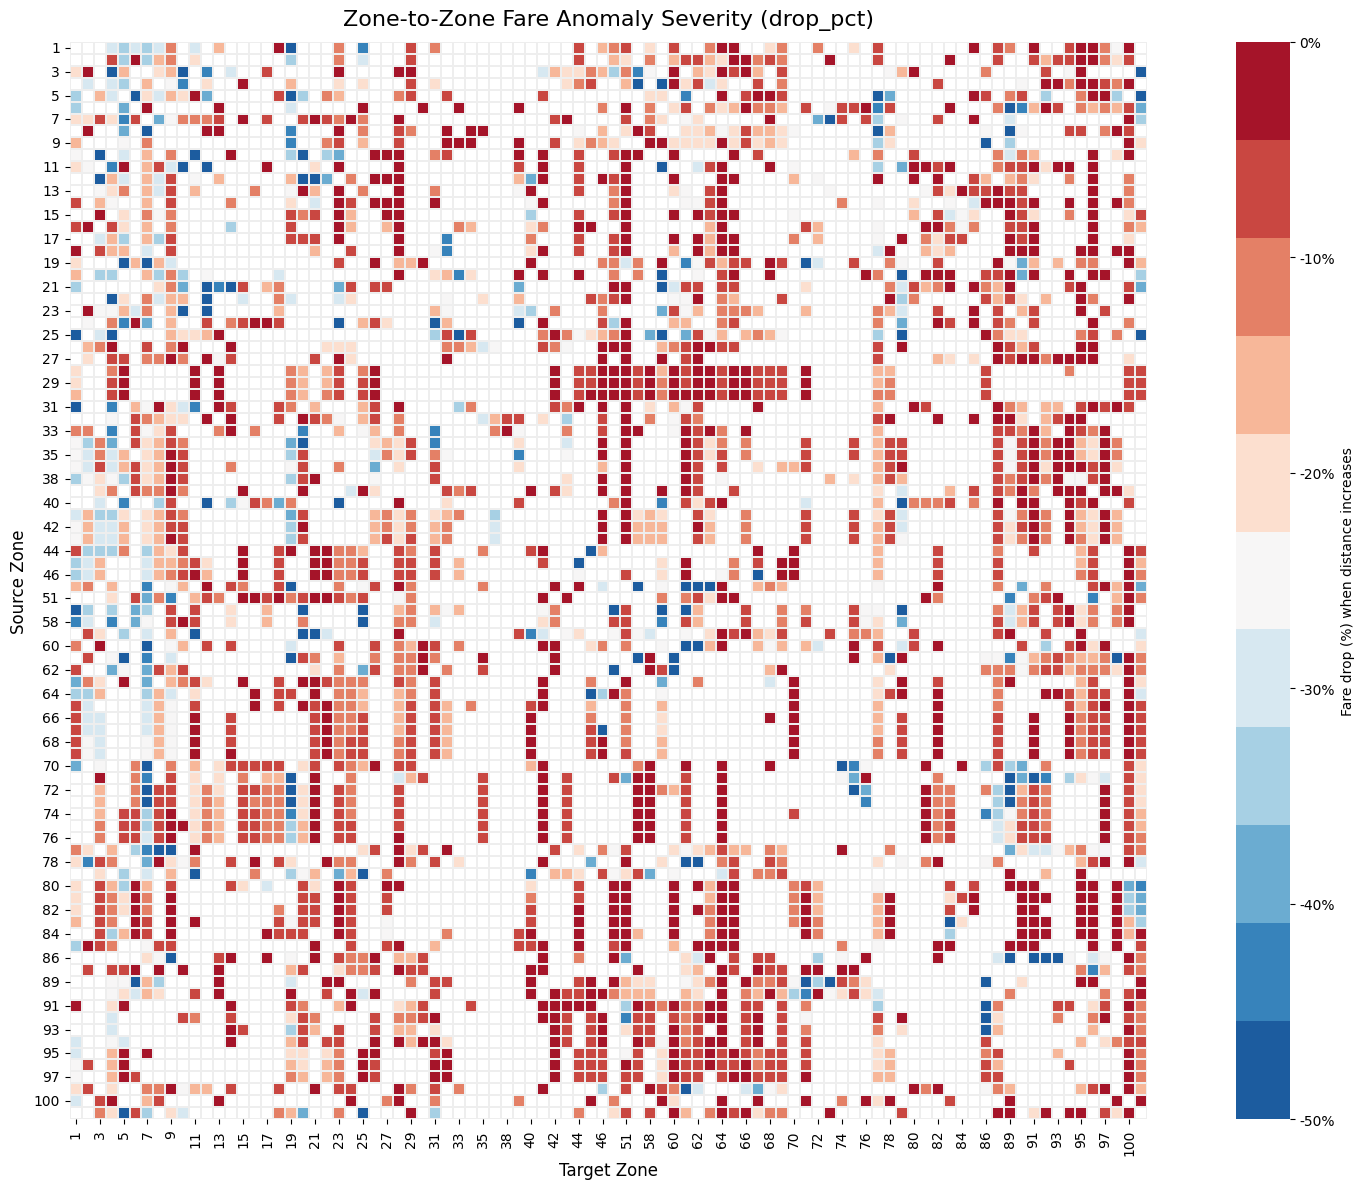

In [63]:
# Seaborn heatmap for anomaly severity
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 12))

# Colormap emphasizing negative drops: reds for negative, gray for NaN (no anomaly)
cmap = sns.color_palette("RdBu_r", 11)  # reversed: blue positive, red negative; we'll clip to [-0.5, 0]
ax = sns.heatmap(
    heatmap_anom,
    cmap=cmap,
    vmin=-0.50,  # -50% drop
    vmax=0.00,   # 0% (no drop)
    linewidths=0.3,
    linecolor="#EEE",
    square=True,
    cbar_kws={'label': 'Fare drop (%) when distance increases'},
    mask=heatmap_anom.isna()
)

ax.set_title("Zone-to-Zone Fare Anomaly Severity (drop_pct)", fontsize=16, pad=12)
ax.set_xlabel("Target Zone", fontsize=12)
ax.set_ylabel("Source Zone", fontsize=12)

# Format colorbar to show percentages
cbar = ax.collections[0].colorbar
cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0.0])
cbar.set_ticklabels(['-50%', '-40%', '-30%', '-20%', '-10%', '0%'])

plt.tight_layout()
plt.show()

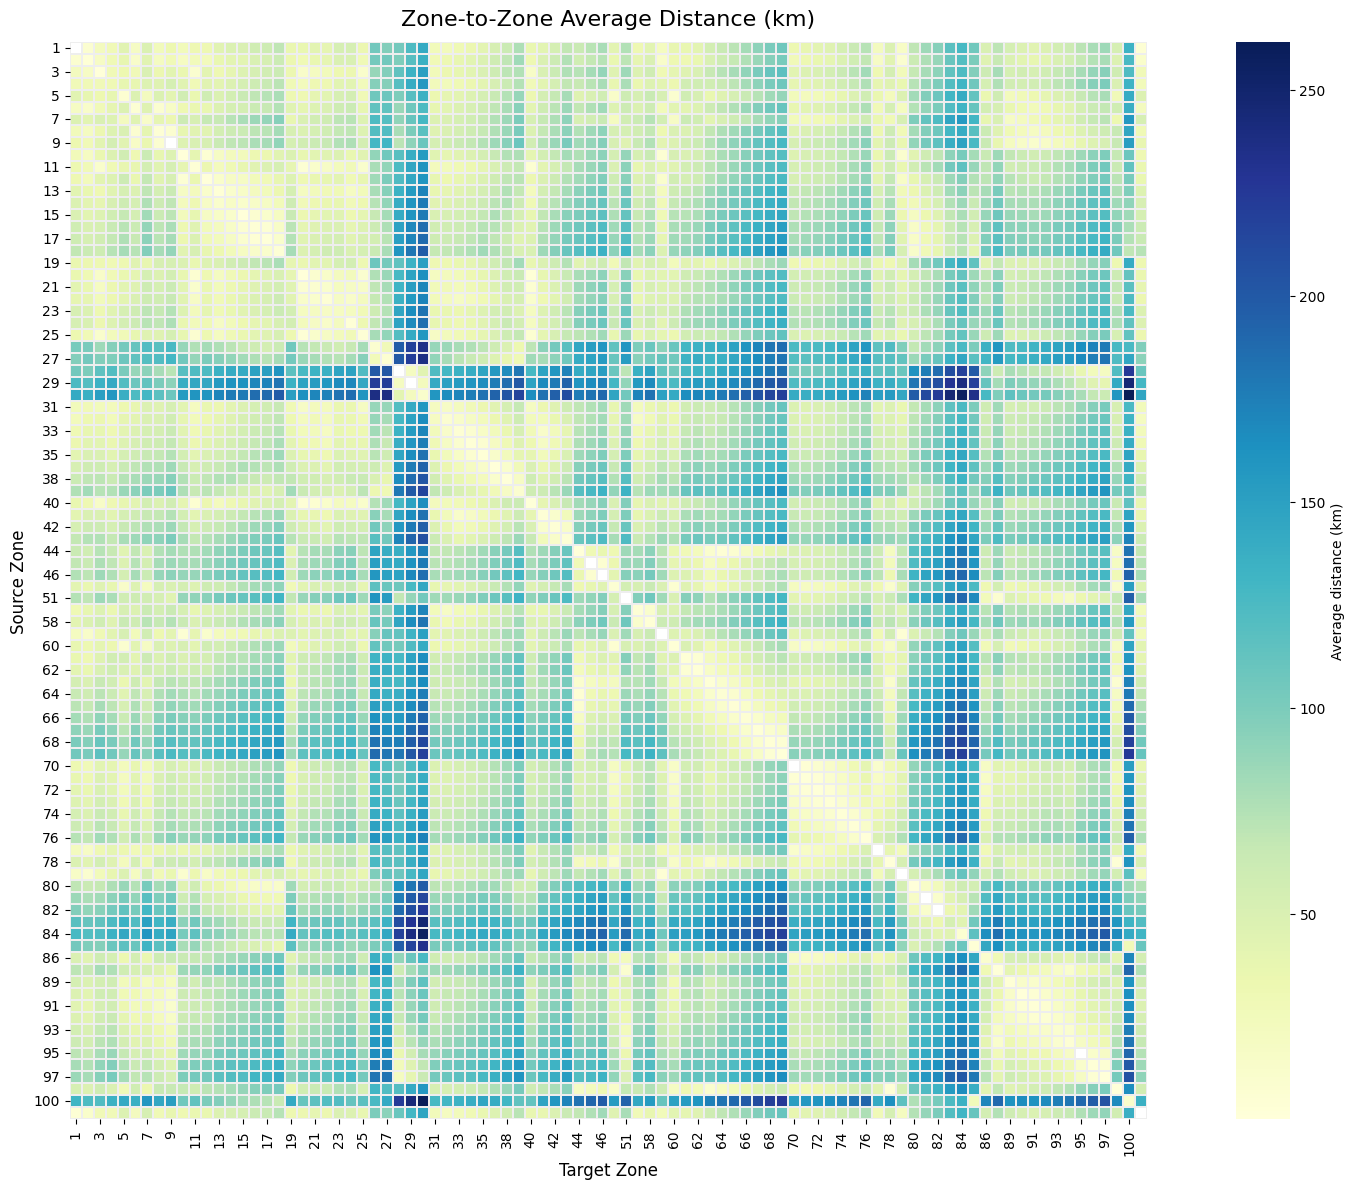

In [64]:
# Cell — Seaborn heatmap for average distance (km)
plt.figure(figsize=(18, 12))

ax = sns.heatmap(
    heatmap_dist,
    cmap="YlGnBu",
    linewidths=0.3,
    linecolor="#EEE",
    square=True,
    cbar_kws={'label': 'Average distance (km)'},
    mask=heatmap_dist.isna()
)

ax.set_title("Zone-to-Zone Average Distance (km)", fontsize=16, pad=12)
ax.set_xlabel("Target Zone", fontsize=12)
ax.set_ylabel("Source Zone", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
stops = stops.iloc[:,:5] \
    .merge(stop_times[['stop_id', 'trip_id']], on='stop_id', how='right') \
    .merge(trips[['trip_id', 'route_id']], on='trip_id', how='left') \
    .merge(routes[['route_id', 'route_short_name', 'route_long_name', 'route_color']], on='route_id', how='left')
stops['route_full_name'] = stops['route_short_name'] + ": " + stops['route_long_name']

stops = stops.drop_duplicates(['stop_id','route_full_name'])[['stop_id','stop_name','stop_lat','stop_lon','zone_id','route_color', 'route_full_name']]
stops["Train"] = stops["stop_id"].apply(lambda x: 1 if x.isalpha() and x != "PA" else 0)
stops["Bus"] = stops["stop_id"].apply(lambda x: 1 if x.isdigit() or x == "PA" else 0)
stops['stop_color'] = stops.apply(
    lambda row: '000000' if row['stop_id'] == 'UN'
    else '696969' if row['Bus'] == 1
    else row['route_color'],
    axis=1
)
stops = stops[['stop_id','stop_name','stop_lat','stop_lon','zone_id',
               'Train','Bus','route_full_name','route_color','stop_color']]
stops['route_color'] = stops['route_color'].apply(
    lambda x: '; '.join(f'#{c}' if not c.startswith('#') else c for c in x.split('; '))
)
stops = stops.sort_values(['stop_id','route_full_name'], ascending=True).reset_index(drop=True)
stops

,stop_id,stop_name,stop_lat,stop_lon,zone_id,Train,Bus,route_full_name,route_color,stop_color
0,00005,Yonge St. @ Baif Blvd. (Hillcrest Mall),43.855755,-79.433876,50,0,1,61: Richmond Hill,#0099c7,696969
1,00006,Yonge St. @ Hwy. 407,43.831982,-79.428383,60,0,1,32: Brampton Trinity Common / North York,#00853e,696969
2,00008,Yonge St. @ Sheppard Ave.,43.761597,-79.411194,5,0,1,19: Mississauga / North York,#f57f25,696969
3,00008,Yonge St. @ Sheppard Ave.,43.761597,-79.411194,5,0,1,27: Milton / North York,#f57f25,696969
4,00008,Yonge St. @ Sheppard Ave.,43.761597,-79.411194,5,0,1,67: Keswick / North York,#003767,696969
...,...,...,...,...,...,...,...,...,...,...
1674,UN,Union Station GO,43.645195,-79.380600,2,1,0,RH: Richmond Hill,#0099c7,000000
1675,UN,Union Station GO,43.645195,-79.380600,2,1,0,ST: Stouffville,#794500,000000
1676,WE,Weston GO,43.700220,-79.514671,4,1,0,KI: Kitchener,#00853e,00853e
1677,WH,Whitby GO,43.864840,-78.938180,93,1,0,LE: Lakeshore East,#ff0d00,ff0d00


In [76]:
# Step 1: Group and collect (route_full_name, route_color) pairs
grouped = stops.groupby('stop_id').agg({
    'stop_name': 'first',
    'stop_lat': 'first',
    'stop_lon': 'first',
    'zone_id': 'first',
    'Train': 'max',
    'Bus': 'max',
    'stop_color': 'first',
    'route_full_name': list,
    'route_color': list
}).reset_index()

# Step 2: Zip full_name and color, drop duplicates while preserving order
def zip_and_clean(names, colors):
    seen = set()
    clean = []
    for name, color in zip(names, colors):
        if name not in seen:
            seen.add(name)
            clean.append((name, color))
    return clean

grouped['route_pairs'] = grouped.apply(
    lambda row: zip_and_clean(row['route_full_name'], row['route_color']), axis=1
)

# Step 3: Separate cleaned tuples into two lists again
grouped['route_full_name'] = grouped['route_pairs'].apply(lambda pairs: '; '.join([p[0] for p in pairs]))
grouped['route_color'] = grouped['route_pairs'].apply(lambda pairs: '; '.join([p[1] for p in pairs]))

# Step 4: Final cleanup
stops_final = grouped.drop(columns=['route_pairs'])

# Create rail_stop_label column
stops_final['rail_stop_label'] = np.select([stops_final['Train'] == 0,stops_final['stop_id'] == 'UN'],
                                           ['Bus','Union Station'],
                                           default=stops_final['route_full_name'])
stops_final

,stop_id,stop_name,stop_lat,stop_lon,zone_id,Train,Bus,stop_color,route_full_name,route_color,rail_stop_label
0,00005,Yonge St. @ Baif Blvd. (Hillcrest Mall),43.855755,-79.433876,50,0,1,696969,61: Richmond Hill,#0099c7,Bus
1,00006,Yonge St. @ Hwy. 407,43.831982,-79.428383,60,0,1,696969,32: Brampton Trinity Common / North York,#00853e,Bus
2,00008,Yonge St. @ Sheppard Ave.,43.761597,-79.411194,5,0,1,696969,19: Mississauga / North York; 27: Milton / Nor...,#f57f25; #f57f25; #003767; #ff0d00,Bus
3,00011,York Mills Bus Terminal,43.745079,-79.406464,5,0,1,696969,33: Guelph / North York; 36: Brampton / North ...,#00853e; #00853e; #ff0d00,Bus
4,00013,Finch Bus Terminal,43.782173,-79.415093,5,0,1,696969,19: Mississauga / North York; 27: Milton / Nor...,#f57f25; #f57f25; #00853e; #003767; #ff0d00,Bus
...,...,...,...,...,...,...,...,...,...,...,...
913,UI,Unionville GO,43.851689,-79.314332,71,1,0,794500,ST: Stouffville,#794500,ST: Stouffville
914,UN,Union Station GO,43.645195,-79.380600,2,1,0,000000,BR: Barrie; KI: Kitchener; LE: Lakeshore East;...,#003767; #00853e; #ff0d00; #98002e; #f57f25; #...,Union Station
915,WE,Weston GO,43.700220,-79.514671,4,1,0,00853e,KI: Kitchener,#00853e,KI: Kitchener
916,WH,Whitby GO,43.864840,-78.938180,93,1,0,ff0d00,LE: Lakeshore East,#ff0d00,LE: Lakeshore East


In [77]:
# Aggregate stop counts by zone
stops_by_zone = (
    stops_final[["zone_id", "stop_id", "Train", "Bus"]]
    .groupby("zone_id")
    .agg(total_stops=("stop_id", "count"),
         train_stops=("Train", "sum"),
         bus_stops=("Bus", "sum"))
    .reset_index()
    # .astype(str)
)

# Merge trips and routes
trips_routes = (
    pd.merge(trips, routes[["route_id", "route_short_name", "route_long_name", "route_color"]],
             on="route_id", how="inner")
    .drop_duplicates(subset=["shape_id", "trip_headsign", "route_id"])
    .assign(route_color=lambda df: "#" + df["route_color"],
            route_full_name=lambda df: df["route_short_name"] + ": " + df["route_long_name"])
    [["shape_id", "trip_headsign", "route_short_name", "route_long_name", "route_full_name", "route_color"]]
)

# Sort shapes by sequence and merge with route info
grouped_shapes = (
    shapes.sort_values(["shape_id", "shape_pt_sequence"])
    .merge(trips_routes, on="shape_id", how="inner")
)

In [78]:
# Load the GeoJSON file containing all polygons coordinates
geojson = folium.GeoJson(os.path.join(config["data_GIS_folder"], 'go_transit_voronoi_zones.geojson'),
                         highlight_function = lambda feat: {'fillColor': 'orange'})

# Access the GeoJson features and add counts
for feature in geojson.data['features']:

    zone_id = feature['properties']['zone_id']
    matching_rows = stops_by_zone.loc[
        stops_by_zone['zone_id'] == zone_id
    ]

    if not matching_rows.empty:
        feature['properties'].update({
            'total_stops': int(matching_rows['total_stops'].iloc[0]),
            'train_stops': int(matching_rows['train_stops'].iloc[0]),
            'bus_stops': int(matching_rows['bus_stops'].iloc[0]),
        })
    else:
        feature['properties'].update({
            'total_stops': 0,
            'train_stops': 0,
            'bus_stops': 0,
        })
        print(f"There are no stops in Zone {zone_id}.")

In [ ]:
# Build inputs for the front-end map
import json, zlib, base64
import pandas as pd
from pathlib import Path

# Inputs
ZONES_GEOJSON_PATH = os.path.join(config["data_GIS_folder"], 
                                  'go_transit_voronoi_zones.geojson')

# anomalies_df columns assumed
assert {'source_zone','target_zone','drop_pct'}.issubset(anomalies_df.columns)

# 1) Build anomaly lookup: dict[source_zone][target_zone] = min_drop_pct
anom_severity = (
    anomalies_df
    .groupby(['source_zone','target_zone'], as_index=False)
    .agg(drop_pct_min=('drop_pct','min'))
)
anomalies_dict = {}
for _, r in anom_severity.iterrows():
    s = str(r['source_zone']); t = str(r['target_zone'])
    anomalies_dict.setdefault(s, {})[t] = float(r['drop_pct_min'])

# 2) Load zone polygons and extract only what's needed for client-side rendering
with open(ZONES_GEOJSON_PATH, "r", encoding="utf-8") as f:
    gj = json.load(f)

# Expect properties.Name to be the zone id; geometry is Polygon / MultiPolygon
zones_payload = []  # [{ "zone": "1", "polygons": [ [ [lat,lon], ...], ... ] }]
for feat in gj.get("features", []):
    props = feat.get("properties", {})
    zone_id = str(props.get("zone_id"))
    geom = feat.get("geometry", {})
    gtype = geom.get("type")
    coords = geom.get("coordinates", [])

    # Normalize to a list of polygons (each polygon is a list of [lat, lon] rings)
    polygons_latlon = []
    if gtype == "Polygon":
        for ring in coords:
            polygons_latlon.append([[lat, lon] for lon, lat in ring])  # GeoJSON is [lon,lat]
    elif gtype == "MultiPolygon":
        for poly in coords:
            for ring in poly:
                polygons_latlon.append([[lat, lon] for lon, lat in ring])

    if polygons_latlon:
        zones_payload.append({
            "zone": zone_id,
            "polygons": polygons_latlon
        })

# Provide a sorted zone list for the dropdown
zone_list = sorted({z["zone"] for z in zones_payload}, key=lambda x: float(x) if str(x).replace('.','',1).isdigit() else x)

# 3) Utility: pack JSON → zlib → base64 (safe for HTML embedding)
def pack(obj) -> str:
    raw = json.dumps(obj, separators=(',', ':')).encode('utf-8')
    comp = zlib.compress(raw, 9)
    return base64.b64encode(comp).decode('ascii')

def js_safe(s: str) -> str:
    # prevent '</script>' early-termination in HTML
    return s.replace('</', '<\\/')

# 4) Create packed blobs for the template
ANOM_PACK = js_safe(pack(anomalies_dict))
ZONES_PACK = js_safe(pack(zones_payload))
LIST_PACK = js_safe(pack(zone_list))

# Build zone->list of target metrics (average_distance, fare)
zone_od_min = zone_od[['source_zone','target_zone','average_distance','fare']].copy()
zone_od_dict = {}
for _, r in zone_od_min.iterrows():
    s = str(r['source_zone']); t = str(r['target_zone'])
    zone_od_dict.setdefault(s, []).append({
        'target_zone': t,
        'average_distance': float(r['average_distance']) if pd.notna(r['average_distance']) else None,
        'fare': float(r['fare']) if pd.notna(r['fare']) else None
    })

ZONEOD_PACK = js_safe(pack(zone_od_dict))


# pack stops for client rendering
stops_min = stops_final[['stop_id','stop_name','stop_lat','stop_lon','Train','Bus','route_full_name','route_color','stop_color']].copy()
# route_color already has '#', ensure stop_color has '#'
stops_min['stop_color'] = stops_min['stop_color'].apply(lambda c: f'#{c}' if not str(c).startswith('#') else c)

stops_payload = [
    {
        'id': str(r.stop_id),
        'name': r.stop_name,
        'lat': float(r.stop_lat),
        'lon': float(r.stop_lon),
        'isTrain': int(r.Train) == 1,
        'isBus': int(r.Bus) == 1,
        'routeNames': str(r.route_full_name).split('; '),
        'routeColors': str(r.route_color).split('; '),
        'stopColor': r.stop_color
    }
    for _, r in stops_min.iterrows()
]

STOPS_PACK = js_safe(pack(stops_payload))

In [129]:
from branca.element import Template, MacroElement
import folium

m = folium.Map(location=[43.645195, -79.3806], zoom_start=10, tiles='cartodbpositron')
template_raw = """
{% macro html(this, kwargs) %}
<style>
  html, body { margin:0; height:100%; }
  #app { display:grid; grid-template-columns:580px 1fr; width:100vw; height:100vh; overflow:hidden; }
  #app.collapsed { grid-template-columns:0 1fr; }

  #sidebar { padding:12px; border-right:1px solid #e5e7eb; background:#fff; overflow:auto; }
  #map-panel { position:relative; }
  #map-panel > .folium-map { position:absolute !important; inset:0 !important; width:100% !important; height:100% !important; }

  /* Single toggle button overlaid on the map, near Leaflet zoom control (top-left) */
  #toggleSidebarBtn {
    position:absolute;
    top:80px;         /* just below the zoom +/- control */
    left:10px;
    z-index:650;      /* above tiles and layers */
    background:#fff;
    border:1px solid #d1d5db;
    border-radius:4px;
    padding:4px 8px;
    font-size:0.75rem;
    cursor:pointer;
    box-shadow:0 1px 3px rgba(0,0,0,0.15);
  }

  .batch-slider-row { margin-top:8px; }
  .batch-slider-controls { display:flex; align-items:center; gap:8px; }
  .batch-slider-controls input[type="range"] { flex:1; }
  .zone-label { background:rgba(255,255,255,0); padding:2px 4px; border:none; font-size:11px; }

  #scatterContainer { margin-top:16px; }
  #zoneScatter { width:100%; height:640px; }
</style>
<script src="https://cdn.jsdelivr.net/npm/pako@2/dist/pako.min.js"></script>
<script src="https://cdn.plot.ly/plotly-2.27.0.min.js"></script>

<div id="sidebar" data-ui="true">
  <h3>GO Transit Fare Zones: Fare vs. Network Distance Explorer</h3>
  <div style="font-size:12px; color:#333; margin:8px 0 12px; line-height:1.5;">
    <p>
      This interactive map and chart explore the relationship between GO Transit fares and the actual distance traveled through the transit network between fare zones. 
      The goal is to understand how pricing between zones compares with real network travel distance, rather than straight-line geography.
    </p>
    <p>
      Distance is measured as network distance, not Euclidean ("as-the-crow-flies") distance. For each pair of zones, the distance shown is the average of the shortest-path 
      distances between all stop pairs across the two zones, calculated along GO Transit routes and transfers.
    </p>
    <hr style="border:none; border-top:1px solid #e5e7eb; margin:8px 0;">
    <strong>Disclaimer</strong><br>
    <span>
      This is an independent, personal project and does not represent official GO Transit fare zones, designs, or policies. All interpretations and views are solely my own.
      Zones are derived from publicly available <a href="https://www.gotransit.com/en/partner-with-us/software-developers" target="_blank" rel="noopener">GO Transit GTFS data</a> 
      using a Voronoi diagram in a projected coordinate reference system. Polygons were clipped to a custom-generated service boundary to ensure all GO Transit stops and routes 
      fall within the study area, then dissolved by zone identifier. Final outputs were reprojected to WGS84 for web visualization. Source code and methodology: <a href="https://github.com/zhenhuasun" target="_blank" rel="noopener">github.com/zhenhuasun</a>
    </span>
  </div>
  <div id="baselineSliderWrap" class="batch-slider-row">
    <div class="batch-slider-controls">
      <button type="button" id="baselinePrevBtn">⯇</button>
      <input type="range" id="baselineBatchIndex" min="0" max="0" step="1" value="0">
      <button type="button" id="baselineNextBtn">⯈</button>
    </div>
    <div style="margin-top:6px;">
      <span>Source Zone ID: </span><strong id="currentZoneText"></strong>
    </div>
  </div>
  <div id="scatterContainer">
    <h4 style="margin:10px 0 4px;">Fare vs. Average Zonal Distance</h4>
    <div id="zoneScatter"></div>
  </div>
</div>

<main id="map-panel">
  <!-- Single toggle button over the map -->
  <button id="toggleSidebarBtn" type="button">Collapse Sidebar</button>
</main>

<script>
document.addEventListener('DOMContentLoaded', function() {
  function unpack(b64) {
    const bin = atob(b64);
    const arr = new Uint8Array(bin.length);
    for (let i=0; i<bin.length; i++) arr[i] = bin.charCodeAt(i);
    const txt = pako.inflate(arr, {to:'string'});
    return JSON.parse(txt);
  }

  const ANOM = unpack('__ANOM_PACK__');
  const ZONES = unpack('__ZONES_PACK__');
  const ZLIST_RAW = unpack('__LIST_PACK__');
  const ZONEOD = unpack('__ZONEOD_PACK__');
  const STOPS = unpack('__STOPS_PACK__');

  function asNum(z) {
    const f = parseFloat(z);
    return isNaN(f) ? null : f;
  }
  const ZLIST = [...ZLIST_RAW].sort((a,b) => {
    const na = asNum(a), nb = asNum(b);
    if (na!=null && nb!=null) return na - nb;
    if (na!=null) return -1;
    if (nb!=null) return 1;
    return String(a).localeCompare(String(b));
  });

  const slider = document.getElementById('baselineBatchIndex');
  const prevBtn = document.getElementById('baselinePrevBtn');
  const nextBtn = document.getElementById('baselineNextBtn');
  const currentZoneText = document.getElementById('currentZoneText');
  const toggleBtn = document.getElementById('toggleSidebarBtn');

  slider.max = Math.max(0, ZLIST.length - 1);
  slider.value = 0;

  const mapDiv = document.querySelector('[id^="map_"].folium-map');
  if (!mapDiv) {
    console.error("Map div not found; aborting.");
    return;
  }
  const parent = mapDiv.parentElement;
  const app = document.createElement('div'); app.id='app';
  const sidebar = document.querySelector('#sidebar[data-ui="true"]');
  const mainPanel = document.getElementById('map-panel');
  parent.insertBefore(app, mapDiv);
  app.appendChild(sidebar);
  app.appendChild(mainPanel);
  mainPanel.appendChild(mapDiv);  // ensure button overlays the map inside #map-panel

  // Toggle sidebar collapsed/expanded and update button label
  function updateToggleLabel() {
    const collapsed = app.classList.contains('collapsed');
    toggleBtn.textContent = collapsed ? 'Expand Sidebar' : 'Collapse Sidebar';
  }
  toggleBtn.addEventListener('click', () => {
    app.classList.toggle('collapsed');
    updateToggleLabel();
  });
  updateToggleLabel();

  const MAP = window[mapDiv.id];
  const BASE_LAYER = L.layerGroup().addTo(MAP);
  const BORDER_LAYER = L.layerGroup().addTo(MAP);
  const LABEL_LAYER = L.layerGroup().addTo(MAP);
  const TARGET_LAYER = L.layerGroup().addTo(MAP);
  const STOPS_LAYER = L.layerGroup().addTo(MAP);

  const zoneFeatures = new Map(); // zoneId -> { polygons:[L.polygon], label:L.marker }
  ZONES.forEach(z => {
    const zoneId = String(z.zone);
    let center = null;
    try {
      const all = z.polygons[0] || [];
      if (all && all.length) {
        const sum = all.reduce((acc,p) => [acc[0]+p[0], acc[1]+p[1]], [0,0]);
        center = [sum[0]/all.length, sum[1]/all.length];
      }
    } catch(e) { center = null; }
    const polys = z.polygons.map(ring => L.polygon(ring, {
      color:'#000', weight:1, fillColor:'#dddddd', fillOpacity:0.0
    }));
    const label = center
      ? L.marker(center, {
          icon: L.divIcon({
            className: 'zone-label',
            html: zoneId
          }),
          interactive: false
        })
      : null;
    zoneFeatures.set(zoneId, { polygons: polys, label });
  });

  function getColor(sev) {
    if (sev === null || sev === undefined) return '#CCCCCC';
    if (sev <= -0.20) return '#FF0000';
    if (sev <= -0.10) return '#FF6600';
    return '#6699FF';
  }

  let currentSourceZone = null;
  let currentPairs = [];
  let selectedTargetZone = null;

  function buildScatter(sourceZone) {
    const raw = (ZONEOD[sourceZone] || []).filter(p => p.fare != null && p.average_distance != null);
    raw.sort((a,b) => a.average_distance - b.average_distance);
    currentPairs = raw;
    const fares = raw.map(p => p.fare);
    const dists = raw.map(p => p.average_distance);
    const tzones = raw.map(p => p.target_zone);
    const colors = raw.map(p => {
      const sev = ANOM[sourceZone] ? ANOM[sourceZone][p.target_zone] : null;
      return getColor(sev);
    });
    const sizes = raw.map(p => p.target_zone === selectedTargetZone ? 20 : 9);
    const lineColors = raw.map(p => p.target_zone === selectedTargetZone ? '#000000' : '#222');
    const lineWidths = raw.map(p => p.target_zone === selectedTargetZone ? 3 : 1);
    const linesTrace = {
      x: fares, y: dists, mode:'lines',
      line: {color:'#444', width:1},
      hoverinfo:'skip',
      showlegend:false
    };
    const scatterTrace = {
      x: fares, y: dists, mode:'markers',
      marker: { size: sizes, color: colors, line: {width:1, color:'#111'} },
      text: tzones,
      customdata: tzones,
      hovertemplate: 'Target Zone ID: %{text}<br>Fare: $%{x:.2f}<br>Avg Distance: %{y:.2f} km<extra></extra>',
      showlegend:false
    };

    const legendTraces = [
      {name:'No fare decrease', mode:'markers', x:[NaN], y:[NaN], showlegend:true, hoverinfo:'skip', visible:'legendonly',
       marker:{size:12, color:'#CCCCCC', line:{color:'#111', width:1}}},
      {name:'≤10% fare decrease vs nearer zone', mode:'markers', x:[NaN], y:[NaN], showlegend:true, hoverinfo:'skip', visible:'legendonly',
       marker:{size:12, color:'#6699FF', line:{color:'#111', width:1}}},
      {name:'10-20% fare decrease vs nearer zone', mode:'markers', x:[NaN], y:[NaN], showlegend:true, hoverinfo:'skip', visible:'legendonly',
       marker:{size:12, color:'#FF6600', line:{color:'#111', width:1}}},
      {name:'>20% fare decrease vs nearer zone', mode:'markers', x:[NaN], y:[NaN], showlegend:true, hoverinfo:'skip', visible:'legendonly',
       marker:{size:12, color:'#FF0000', line:{color:'#111', width:1}}},
    ];

    const layout = {
      margin: {l:40,r:10,t:10,b:40},
      xaxis: { title:'Fare (CAD)', zeroline:false },
      yaxis: { title:'Average Zonal Distance (km)', autorange:'reversed' },
      dragmode:'pan',
      legend: {
        orientation: 'v',
        x: 1, xanchor: 'right',
        y: 0.95, yanchor: 'top',
        bgcolor: 'rgba(255,255,255,0.25)'
      }
    };
    Plotly.react('zoneScatter', [linesTrace, scatterTrace, ...legendTraces], layout, {displayModeBar:false});
    const el = document.getElementById('zoneScatter');
    el.on('plotly_click', ev => {
      const zoneId = ev.points[0].customdata;
      onZoneClick(zoneId);
    });
  }

  function highlightPoint(zoneId) {
    selectedTargetZone = zoneId;
    const sizes = currentPairs.map(p => p.target_zone === zoneId ? 20 : 9);
    const lineColors = currentPairs.map(p => p.target_zone === zoneId ? '#000000' : '#222');
    const lineWidths = currentPairs.map(p => p.target_zone === zoneId ? 3 : 1);
    Plotly.restyle('zoneScatter', {
      'marker.size':[sizes],
      'marker.line.color':[lineColors],
      'marker.line.width':[lineWidths]
    }, [1]);
  }

  function highlightTargetPolygon(zoneId) {
    TARGET_LAYER.clearLayers();
    const coloredGroup = zoneColoredGroups.get(zoneId);
    if (!coloredGroup) return;
    coloredGroup.getLayers().forEach(poly => {
      const latlngs = poly.getLatLngs();
      L.polygon(latlngs, {
        color:'#000', weight:5, opacity:0.8, fillOpacity:0.0
      }).addTo(TARGET_LAYER);
    });
  }

  function onZoneClick(zoneId) {
    if (zoneId === currentSourceZone) return;
    highlightPoint(zoneId);
    highlightTargetPolygon(zoneId);
  }

  const zoneColoredGroups = new Map();

  function renderStops() {
    STOPS_LAYER.clearLayers();
    STOPS.forEach(s => {
      const radius = s.isTrain ? 200 : 20;
      const tooltipHtml = `
        <div style="font-family: Arial; font-size: 12px">
          <div><strong>Stop Name:</strong></div>
          ${s.name} (${s.isTrain ? 'Rail' : 'Bus'})
          <div><strong>Route(s):</strong></div>
          ${s.routeNames.map((nm, i) => `<div style="color:${s.routeColors[i] || '#333'}">${nm}</div>`).join('')}
        </div>
      `;
      L.circle([s.lat, s.lon], {
        radius: radius,
        color: s.stopColor,
        fillColor: s.stopColor,
        fillOpacity: 0.5,
        weight: 1
      }).bindTooltip(tooltipHtml, {sticky:true}).addTo(STOPS_LAYER);
    });
  }

  function render(sourceZone) {
    currentSourceZone = sourceZone;
    BASE_LAYER.clearLayers();
    BORDER_LAYER.clearLayers();
    LABEL_LAYER.clearLayers();
    TARGET_LAYER.clearLayers();
    zoneColoredGroups.clear();

    ZONES.forEach(z => {
      const zoneId = String(z.zone);
      const feat = zoneFeatures.get(zoneId);
      if (feat && feat.label) feat.label.addTo(LABEL_LAYER);
    });

    ZONES.forEach(z => {
      const zoneTarget = String(z.zone);
      const sev = ANOM[sourceZone] ? ANOM[sourceZone][zoneTarget] : null;
      const col = getColor(sev);
      const group = L.featureGroup(
        z.polygons.map(ring => {
          const poly = L.polygon(ring, {
            color:'#000', weight:1, fillColor:col, fillOpacity:0.65
          });
          poly.on('click', () => onZoneClick(zoneTarget));
          return poly;
        })
      ).bindTooltip(`Zone: ${zoneTarget}<br>` +
        (sev!=null
          ? `Fare change vs nearer zone: ${(-Math.abs(sev)*100).toFixed(1)}%`
          : `No fare decrease`
        ), {sticky:true});
      group.addTo(BASE_LAYER);
      zoneColoredGroups.set(zoneTarget, group);
    });

    const srcFeat = zoneFeatures.get(sourceZone);
    if (srcFeat) {
      const borderGroup = L.featureGroup(
        srcFeat.polygons.map(poly => {
          const latlngs = poly.getLatLngs();
          return L.polygon(latlngs, {
            color:'#497824',
            weight:5,
            opacity:0.8,
            fillOpacity:0.0
          });
        })
      );
      borderGroup.addTo(BORDER_LAYER);
    }

    currentZoneText.textContent = sourceZone;
    buildScatter(sourceZone);
    renderStops();
  }

  function setIndex(idx) {
    const clamped = Math.max(0, Math.min(ZLIST.length - 1, idx));
    slider.value = clamped;
    const srcZone = ZLIST[clamped];
    selectedTargetZone = null;
    render(srcZone);
  }

  slider.addEventListener('input', () => setIndex(parseInt(slider.value, 10)));
  prevBtn.addEventListener('click', () => setIndex(parseInt(slider.value, 10) - 1));
  nextBtn.addEventListener('click', () => setIndex(parseInt(slider.value, 10) + 1));

  setIndex(0);
});
</script>
{% endmacro %}
"""

# Inject packed blobs safely
template = template_raw \
    .replace('__ANOM_PACK__', ANOM_PACK) \
    .replace('__ZONES_PACK__', ZONES_PACK) \
    .replace('__LIST_PACK__', LIST_PACK) \
    .replace('__ZONEOD_PACK__', ZONEOD_PACK) \
    .replace('__STOPS_PACK__', STOPS_PACK)

macro = MacroElement()
macro._template = Template(template)
m.get_root().add_child(macro)

m.save(os.path.join(config["outputs_folder"],
                    "05_go_transit_zone_to_zone_fare_network_distance_explorer.html"))

In [ ]:
# Load the GeoJSON file containing all polygons coordinates
geojson = folium.GeoJson(os.path.join(config["data_GIS_folder"], 'go_transit_voronoi_zones.geojson'),
                         highlight_function = lambda feat: {'fillColor': 'orange'})

# Access the GeoJson features and add counts
for feature in geojson.data['features']:

    zone_id = feature['properties']['zone_id']
    matching_rows = stops_by_zone.loc[
        stops_by_zone['zone_id'] == zone_id
    ]

    if not matching_rows.empty:
        feature['properties'].update({
            'total_stops': int(matching_rows['total_stops'].iloc[0]),
            'train_stops': int(matching_rows['train_stops'].iloc[0]),
            'bus_stops': int(matching_rows['bus_stops'].iloc[0]),
        })
    else:
        feature['properties'].update({
            'total_stops': 0,
            'train_stops': 0,
            'bus_stops': 0,
        })
        print(f"There are no stops in Zone {zone_id}.")

In [ ]:
# Load the GeoJSON file containing all polygons coordinates
geojson = folium.GeoJson(os.path.join(config["data_GIS_folder"], 'go_transit_voronoi_zones.geojson'),
                         highlight_function = lambda feat: {'fillColor': 'orange'})

# Access the GeoJson features and add counts
for feature in geojson.data['features']:

    zone_id = feature['properties']['zone_id']
    matching_rows = stops_by_zone.loc[
        stops_by_zone['zone_id'] == zone_id
    ]

    if not matching_rows.empty:
        feature['properties'].update({
            'total_stops': int(matching_rows['total_stops'].iloc[0]),
            'train_stops': int(matching_rows['train_stops'].iloc[0]),
            'bus_stops': int(matching_rows['bus_stops'].iloc[0]),
        })
    else:
        feature['properties'].update({
            'total_stops': 0,
            'train_stops': 0,
            'bus_stops': 0,
        })
        print(f"There are no stops in Zone {zone_id}.")